<a href="https://colab.research.google.com/github/PaulinaRuizB/Machine_Learning_Theory/blob/main/Task_2_Linear_projection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyección de un vector sobre otro: Solución analítica vs. iterativa

Queremos proyectar un vector $b$ sobre un vector $a$.  
Buscamos el escalar $w$ tal que $w \cdot a$ se acerque lo más posible a $b$, minimizando el error cuadrático medio:

$$
J(w) \;=\; \frac{1}{N} \sum_{i=1}^{N} (w a_i - b_i)^2
$$

---

## Solución Analítica

Derivamos el costo respecto a $w$ y lo igualamos a cero:

$$
\frac{dJ}{dw} = \frac{2}{N} \sum_{i=1}^N a_i (w a_i - b_i) = 0
$$

De ahí obtenemos:

$$
w^* \;=\; \frac{\langle a, b \rangle}{\langle a, a \rangle}
$$

Es decir, el coeficiente de proyección es el **cociente entre el producto interno de $a$ y $b$, y la norma cuadrada de $a$**.

---

## Solución Iterativa (Gradiente Descendente)

En gradiente descendente, actualizamos $w$ paso a paso:

$$
w_{t+1} \;=\; w_t \;-\; \eta \, \frac{dJ}{dw}\bigg|_{w_t}
$$

Donde $\eta$ es la **tasa de aprendizaje**.  
El gradiente es:

$$
\frac{dJ}{dw} = \frac{2}{N} \sum_{i=1}^N (a_i^2 w - a_i b_i) = 2(Aw - B)
$$

con

$$
A = \frac{1}{N}\sum_{i=1}^N a_i^2,
\quad B = \frac{1}{N}\sum_{i=1}^N a_i b_i
$$


## Librerías e importación de imágenes

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps


from google.colab import files
uploaded = files.upload()   # subes al menos 2 imágenes
paths = list(uploaded.keys())[:2]  # tomamos las 2 primeras

Saving oso2.jpg to oso2 (3).jpg
Saving oso1.jpg to oso1 (3).jpg


## Funciones

In [10]:
# =============== UTILIDADES BÁSICAS ===============

def load_image_vector(path, size=(260, 260), mode="RGB", normalize=True):
    """Carga imagen, corrige orientación EXIF, convierte a 'mode', redimensiona, y devuelve (PIL, vector 1D float64)."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"No existe: {path}")
    img = Image.open(path)
    img = ImageOps.exif_transpose(img).convert(mode)
    img = img.resize(size)
    arr = np.array(img, dtype=np.float64)
    if normalize:
        arr = arr / 255.0
    vec = arr.flatten()
    return img, vec

# =============== NÚCLEO: SOLUCIÓN ANALÍTICA + GD ===============

def solve_projection(a, b, auto_eta=True, eta=None, iters=500, title="",
                     c_auto=0.2, tol_grad=1e-12, tol_w=1e-10, verbose=True, plot=True,
                     plot_convergence=True):
    """
    Calcula proyección analítica y por GD 1D de b sobre a.
    J(w) = mean((w a - b)^2)
    - auto_eta: si True, auto-elige eta ≈ c_auto/(||a||^2/N) para convergencia estable.
    - plot: grafica J(w) vs w + trayectoria de GD y el punto analítico.
    - plot_convergence: grafica J_hist y |w_t - w*| vs iteración (convergencia).
    """
    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    assert a.shape == b.shape, "a y b deben tener la misma forma"

    # --- Analítica ---
    denom = np.dot(a, a) + 1e-12
    w_star = float(np.dot(a, b) / denom)

    # --- Parámetros coherentes con J(w)=mean((w a - b)^2) ---
    N = a.size
    A = np.dot(a, a) / N
    B = np.dot(a, b) / N

    if auto_eta:
        eta = float(c_auto / (A + 1e-18))  # paso adaptado y estable
    elif eta is None:
        eta = 1e-3

    def J(w):
        err = w * a - b
        return float(np.mean(err**2))

    # --- Gradiente Descendente 1D ---
    w = 0.0
    w_hist = [w]
    J_hist = [J(w)]
    for t in range(iters):
        # grad = 2(Aw - B)
        grad = 2.0 * (A * w - B)
        if abs(grad) < tol_grad:
            break
        w_next = w - eta * grad
        # parada por cambio pequeño en w
        if abs(w_next - w) < tol_w * max(1.0, abs(w)):
            w = w_next
            w_hist.append(w)
            J_hist.append(J(w))
            break
        w = w_next
        w_hist.append(w)
        J_hist.append(J(w))

    w_gd_final = w
    if verbose:
        print("\n=== Resumen proyección ===")
        print(f"A={A:.6e}  B={B:.6e}  eta={eta:.6e}")
        print(f"w* analítico : {w_star:.12f}")
        print(f"w_final (GD) : {w_gd_final:.12f}")
        print(f"|w_GD - w*|  : {abs(w_gd_final - w_star):.3e}")
        print(f"J(w*)        : {J(w_star):.12e}")
        print(f"J(w_GD)      : {J_hist[-1]:.12e}")
        print(f"Iteraciones  : {len(w_hist)-1}")
        if abs(w_gd_final - w_star) > tol_w:
            print("⚠️ Aviso: w_GD y w* difieren más que la tolerancia. "
                  "Prueba aumentar iters o usar c_auto más grande (p.ej. 0.5).")
        print("==========================\n")

    # --- Gráfica: J(w) vs w + trayectoria GD + punto analítico ---
    if plot:
        w_path = np.array(w_hist); J_path = np.array(J_hist)
        w_lo = min(w_path.min(), w_star); w_hi = max(w_path.max(), w_star)
        pad_x = 0.3 * max(w_hi - w_lo, 1.0)
        w_grid = np.linspace(w_lo - pad_x, w_hi + pad_x, 400)
        J_grid = [J(wv) for wv in w_grid]
        J_star = J(w_star)

        plt.figure(figsize=(10, 6))
        plt.plot(w_grid, J_grid, label="J(w) = MSE(w·a, b)")
        plt.plot(w_path, J_path, marker='o', linewidth=1.5, label='Trayectoria (GD)')
        plt.plot([w_star], [J_star], 'go', markersize=8, label='Solución Analítica (w*)')
        # Flechas (muestras) para pasos GD
        dw = np.diff(w_path); dJ = np.diff(J_path)
        if len(dw) > 0:
            rng_w = max(w_hi - w_lo, 1e-9)
            rng_J = max(J_path.max() - J_path.min(), 1e-9)
            s_w = 0.2 * rng_w / (np.max(np.abs(dw)) + 1e-12)
            s_J = 0.2 * rng_J / (np.max(np.abs(dJ)) + 1e-12)
            step = max(1, len(dw) // 20)
            plt.quiver(w_path[:-1:step], J_path[:-1:step],
                       (dw * s_w)[::step], (dJ * s_J)[::step],
                       angles='xy', scale_units='xy', scale=1.0,
                       width=0.006, alpha=0.85, label='Pasos GD (muestras)')

        plt.xlabel('w (coeficiente de proyección)')
        plt.ylabel('Costo J(w) = MSE')
        t = "Costo vs w — Proyección b sobre a"
        if title:
            t += f" ({title})"
        plt.title(t)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # --- Gráfica de convergencia: J_hist y |w - w*| vs iteración ---
    if plot_convergence:
        w_path = np.array(w_hist); J_path = np.array(J_hist)
        err_w = np.abs(w_path - w_star)

        # J(w_t) vs iter
        plt.figure(figsize=(9, 4.5))
        plt.plot(J_path, marker='o', linewidth=1.5)
        plt.xlabel('Iteración')
        plt.ylabel('J(w_t)')
        plt.title('Convergencia: Costo J(w_t) por iteración')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # |w_t - w*| vs iter (escala log si ayuda)
        plt.figure(figsize=(9, 4.5))
        plt.plot(err_w, marker='o', linewidth=1.5)
        plt.xlabel('Iteración')
        plt.ylabel('|w_t - w*|')
        plt.title('Convergencia: Error en w por iteración')
        plt.yscale('log')  # útil para ver caídas rápidas
        plt.grid(True, which='both', alpha=0.3)
        plt.tight_layout()
        plt.show()

    return {
        "w_star": w_star,
        "w_gd_final": w_gd_final,
        "w_hist": w_hist,
        "J_hist": J_hist,
        "A": A, "B": B, "eta": eta
    }

# =============== GRÁFICA 2D PARA VECTORES CORTOS ===============

def plot_2d_projection(a2, b2, w_star=None, w_gd=None):
    """
    Grafica en el plano:
    - vector a
    - vector b
    - proyección analítica (si w_star se da)
    - proyección GD (si w_gd se da)
    - recta span(a)
    """
    a2 = np.asarray(a2, dtype=np.float64)
    b2 = np.asarray(b2, dtype=np.float64)
    assert a2.shape == (2,) and b2.shape == (2,), "a2 y b2 deben ser 2D"

    proj_analytic = w_star * a2 if w_star is not None else None
    proj_gd = w_gd * a2 if w_gd is not None else None

    plt.figure(figsize=(8, 6))
    plt.quiver(0, 0, a2[0], a2[1], angles='xy', scale_units='xy', scale=1, label='Vector a')
    plt.quiver(0, 0, b2[0], b2[1], angles='xy', scale_units='xy', scale=1, label='Vector b')
    if proj_analytic is not None:
        plt.quiver(0, 0, proj_analytic[0], proj_analytic[1],
                   angles='xy', scale_units='xy', scale=1, label='Proyección Analítica')
    if proj_gd is not None:
        plt.plot([0, proj_gd[0]], [0, proj_gd[1]],
                 linestyle='--', label='Proyección (GD)')

    # Recta span(a)
    x = np.linspace(-5, 10, 200)
    y = (a2[1]/a2[0]) * x if a2[0] != 0 else np.zeros_like(x)
    plt.plot(x, y, '--', alpha=0.5, label='Span(a)')

    plt.xlim([-2, 10]); plt.ylim([-2, 10])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('X'); plt.ylabel('Y')
    plt.title('Proyección de b sobre a (2D)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Función principal


=== Resumen proyección ===
A=3.173774e-01  B=1.958700e-01  eta=6.301646e-01
w* analítico : 0.617151761750
w_final (GD) : 0.617151761643
|w_GD - w*|  : 1.069e-10
J(w*)        : 6.961659140882e-02
J(w_GD)      : 6.961659140882e-02
Iteraciones  : 44
⚠️ Aviso: w_GD y w* difieren más que la tolerancia. Prueba aumentar iters o usar c_auto más grande (p.ej. 0.5).



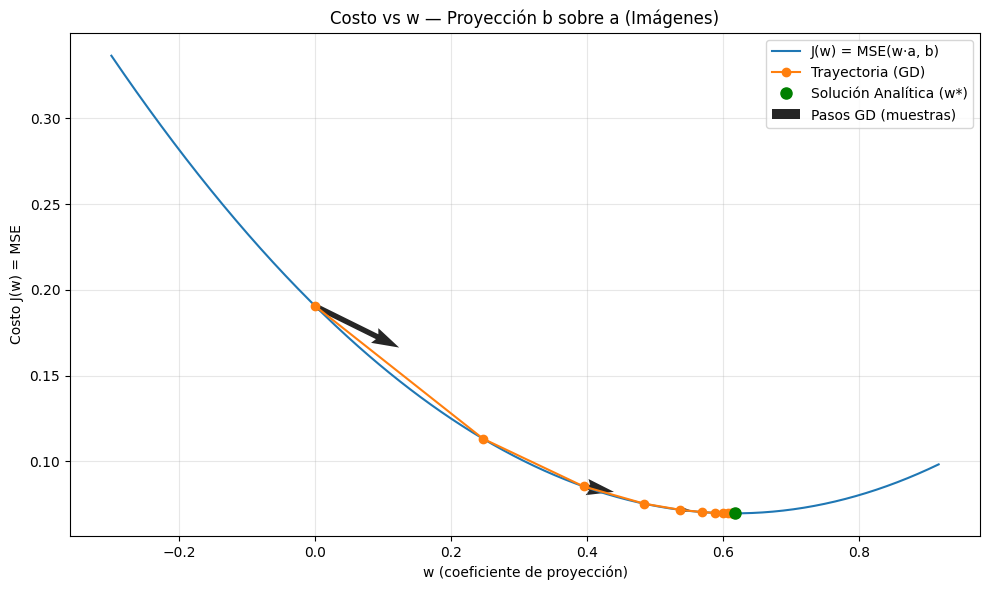

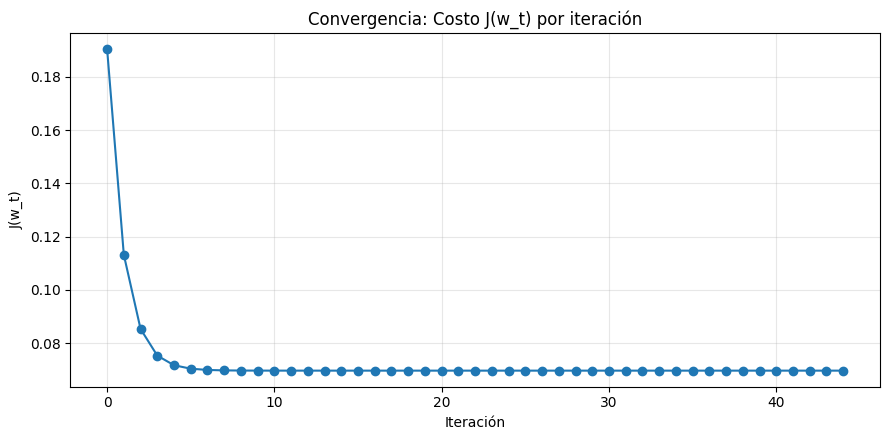

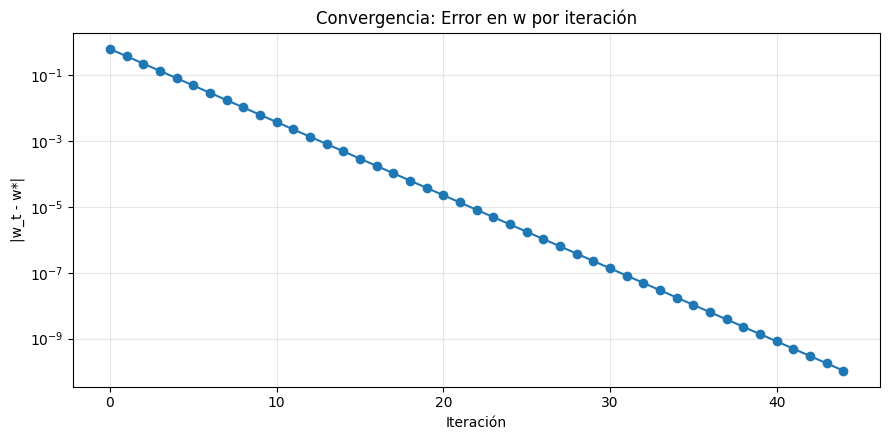

Ejemplo 2D (vectores cortos):

=== Resumen proyección ===
A=1.250000e+01  B=1.250000e+01  eta=2.400000e-02
w* analítico : 1.000000000000
w_final (GD) : 0.999999999955
|w_GD - w*|  : 4.500e-11
J(w*)        : 1.250000000000e+01
J(w_GD)      : 1.250000000000e+01
Iteraciones  : 26



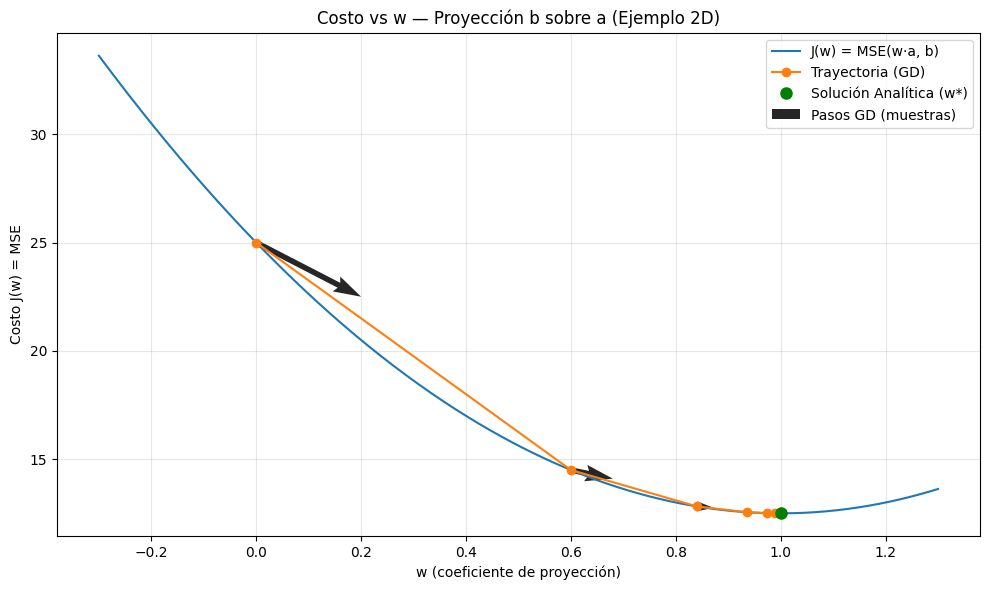

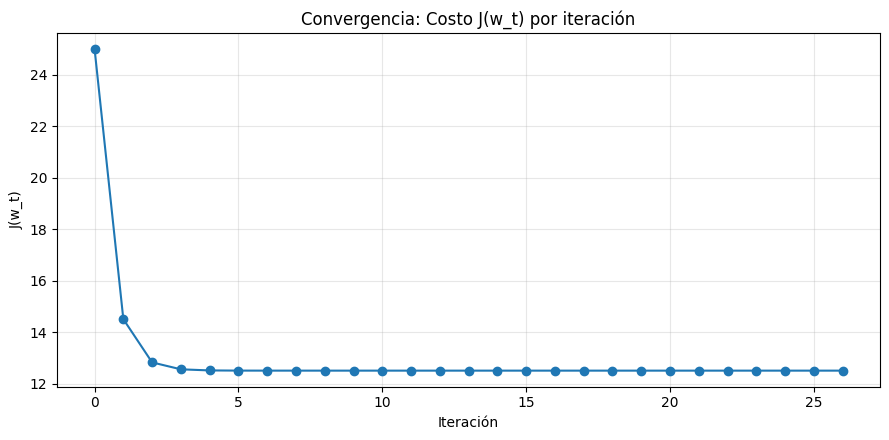

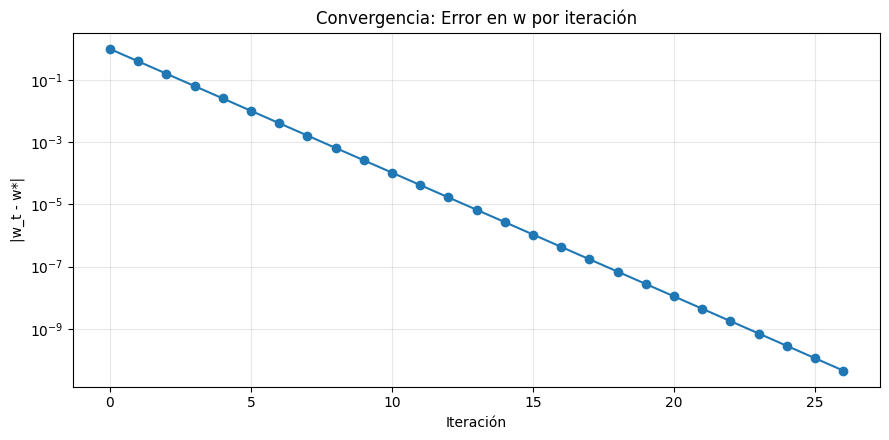

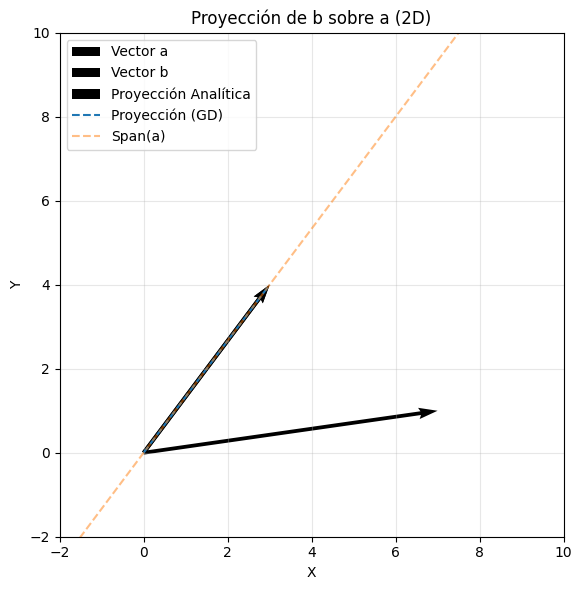

In [11]:
# =============== MAIN: IMÁGENES + VECTORES 2D ===============

def main():

    # Cargar y vectorizar (mismo tamaño/mode, normalizado a [0,1])
    TARGET_SIZE = (260, 260)
    MODE = "RGB"
    _, a = load_image_vector(paths[0], size=TARGET_SIZE, mode=MODE, normalize=True)
    _, b = load_image_vector(paths[1], size=TARGET_SIZE, mode=MODE, normalize=True)

    # Resolver y graficar costo vs w + convergencia
    res_img = solve_projection(a, b, auto_eta=True, iters=300, title="Imágenes",
                               c_auto=0.2, plot=True, plot_convergence=True)

    # --- Caso VECTORES 2D (ejemplo numérico pequeño) ---
    print("Ejemplo 2D (vectores cortos):")
    a2 = np.array([3, 4], dtype=np.float64)
    b2 = np.array([7, 1], dtype=np.float64)

    # Obtenemos w*, w_GD y mostramos también convergencia
    res_2d = solve_projection(a2, b2, auto_eta=True, iters=50, title="Ejemplo 2D",
                              c_auto=0.3, plot=True, plot_convergence=True)

    # Graficar en el plano 2D la proyección analítica y la de GD
    plot_2d_projection(a2, b2, w_star=res_2d["w_star"], w_gd=res_2d["w_gd_final"])

if __name__ == "__main__":
    main()